## 추천시스템 분석 입문하기 3강 - 컨텐츠 기반모델 - Word2Vec

출처 : https://www.youtube.com/watch?v=3jfHP0Rq1Gg&list=PL9mhQYIlKEhdkOVTZWJJIy8rv6rQaZNNc&index=3

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [3]:
import warnings
warnings.filterwarnings(action = 'ignore')

##### 간단한 word2vec 구현해보기
sentence = you say goodbye and I say hello

CBOW 과정. say를 학습하기

In [10]:
# 원핫 형태의 입력값을 win과 곱

input1 = np.array([[1,0,0,0,0,0,0]]) # you
input2 = np.array([[0,0,1,0,0,0,0]]) # goodbye

In [11]:
# (입력 x 차원의 크기) - 차원의 크기는 하이퍼파라미터. 5차원으로 해보자!
# 초기 weight는 랜덤값
W_in = np.random.randn(7,5)

In [12]:
#은닉층의 값
h_1 = np.matmul(input1, W_in)
h_2 = np.matmul(input2, W_in)

In [13]:
print((h_1+h_2)/2)

[[0.06942125 0.54353895 0.13643647 1.08803196 0.39629566]]


In [15]:
# hidden state의 값을 W_out과 곱해서 Score를 추출한다
# Score에 Softmax를 취해서 각 단어가 나올 확률을 계산한다.

h = (h_1+h_2)/2
W_out = np.random.randn(5,7)
score = np.matmul(h,W_out)
print(np.round(score,4))

[[ 0.0764 -0.0314  1.4682 -0.3266 -0.427   0.1505 -2.3006]]


In [16]:
# soft max define

def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

In [18]:
pred = softmax(score)
print(np.round(pred,4))

[[0.1196 0.1074 0.481  0.0799 0.0723 0.1288 0.0111]]


In [21]:
# 정답과 cross entropy loss를 계산해준다

# cross entropy define
def cross_entropy_loss(y, t):
        '''
        y : prediction
        t = target
        '''
        delta = 1e-7 # log의 내부가 0이되는것을 방지(스무딩?)
        
        # y.shpae[0]으로 나눠주는 이유는 배치 사이즈 반영
        return -np.sum(t + np.log(y + delta)) / y.shape[0]

In [22]:
cross_entropy_loss(pred, [0,1,0,0,0,0,0])

15.79148245939156

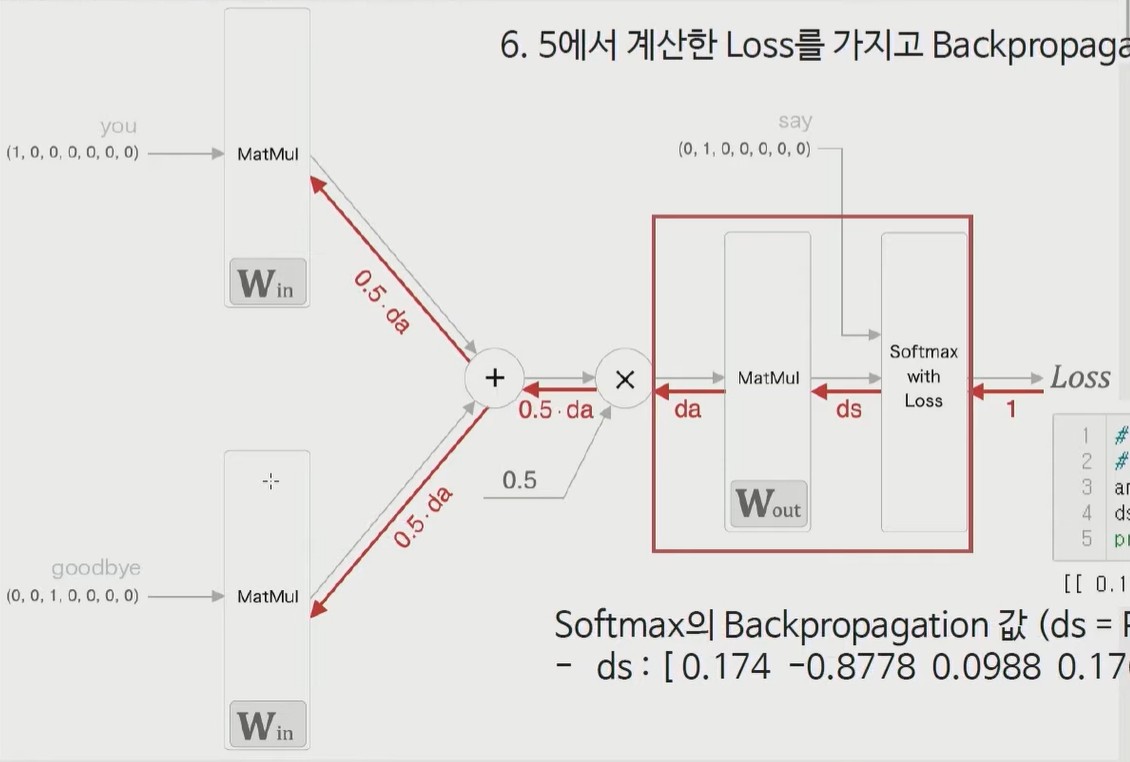

In [24]:
# 계산한 loss를 가지고 BP를 통해 weight를 업데이트
# softmax의 미분값

ans = [0,1,0,0,0,0,0]
ds = np.round(pred - ans, 4)
print(ds)
# ds = Pi - yi

[[ 0.1196 -0.8926  0.481   0.0799  0.0723  0.1288  0.0111]]


In [25]:
# ds(Delta for W_out) 계산
dW_out = np.outer(h, ds)
print(np.round(dW_out,4))

[[ 8.300e-03 -6.200e-02  3.340e-02  5.500e-03  5.000e-03  8.900e-03
   8.000e-04]
 [ 6.500e-02 -4.852e-01  2.614e-01  4.340e-02  3.930e-02  7.000e-02
   6.000e-03]
 [ 1.630e-02 -1.218e-01  6.560e-02  1.090e-02  9.900e-03  1.760e-02
   1.500e-03]
 [ 1.301e-01 -9.712e-01  5.233e-01  8.690e-02  7.870e-02  1.401e-01
   1.210e-02]
 [ 4.740e-02 -3.537e-01  1.906e-01  3.170e-02  2.870e-02  5.100e-02
   4.400e-03]]


In [26]:
# 계산한 loss를 가지고 BP 과정을 통해서  Weight를 업데이트
# W_in_new = W_in - lr*dw-in
da = np.dot(ds, W_out.T)
print(np.round(da, 4))

[[-0.9261  0.1179 -1.0947  1.4162 -1.7945]]


In [27]:
dw_1 = np.round(np.outer(np.array([[1,0,0,0,0,0,0]]), (da/2)), 4)
print(dw_1)

[[-0.463   0.059  -0.5473  0.7081 -0.8972]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]]


In [29]:
dw_2 = np.round(np.outer(np.array([[0,0,1,0,0,0,0]]), (da/2)), 4)
print(dw_2)

[[-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.463   0.059  -0.5473  0.7081 -0.8972]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]]


위 과정을 계속 실행해주면된다!

----------

skip-gram의 경우 하나의 인풋(say)을 받아서 두가지 아웃풋(you, goodbye)이 나오는구조

1. 원핫 벡터 형태의 입력값을 받는다
    - say -> you 예측
    - say - > goodbye 예측
        - 주변단어 : 주변에 있는 단어 (you, goodbye)
        - 중심단어 : 중간에 있는 단어 (say)
        - 윈도우 크기 : 주변을 몇 칸으로 볼 건지에 대한 크기(1) / 만약 윈도우가 2면 say를 통해 you, goodbye, and를 예측

2. 원핫 벡터 형태의 입력값을 Win과 곱

In [30]:
input = np.array([[0,1,0,0,0,0,0]]) # say

output1 = np.array([[1,0,0,0,0,0,0]]) # you
output2 = np.array([[0,0,1,0,0,0,0]]) # goodbye

In [32]:
# (입력 * 차원의 크기) - 차원의 크기는 하이퍼파라미터
## 초기의 weight는 랜덤값으로(5)
W_in = np.random.randn(7,5)
h = np.matmul(input, W_in) # 은닉층 값
print(h)

[[-0.36339093 -1.11421756 -0.16640151 -0.64067307  1.09727876]]


3. Hiddem state의 값을 W_out과 곱해서 Score를 추출

4. Score에 Softmax를 취해서 각 단어가 나올 확률을 계산한다.

In [33]:
W_out = np.random.randn(5,7)
score = np.matmul(h,W_out)
print(np.round(score, 4))

[[ 1.04   -0.4892 -0.0271 -0.0884 -2.1197 -1.7835  2.1477]]


In [34]:
pred = softmax(score)
print(np.round(pred, 4))

[[0.1995 0.0432 0.0686 0.0645 0.0085 0.0118 0.6038]]


5. 정답과 Cross Entropy Loss 계산

6. 5에서 계산한 loss를 가지고 BP 과정을 통해서 weight를 업데이트
    - 두 개의 answer에 대해서 오차를 더함

In [35]:
ds1 = np.round(pred - output1, 4)
ds2 = np.round(pred - output2, 4)
ds = ds1 + ds2
print(ds)

[[-0.601   0.0864 -0.8628  0.129   0.017   0.0236  1.2076]]


In [36]:
dw_out = np.round(np.outer(h, ds), 4)
print(dw_out)

[[ 0.2184 -0.0314  0.3135 -0.0469 -0.0062 -0.0086 -0.4388]
 [ 0.6696 -0.0963  0.9613 -0.1437 -0.0189 -0.0263 -1.3455]
 [ 0.1    -0.0144  0.1436 -0.0215 -0.0028 -0.0039 -0.2009]
 [ 0.385  -0.0554  0.5528 -0.0826 -0.0109 -0.0151 -0.7737]
 [-0.6595  0.0948 -0.9467  0.1415  0.0187  0.0259  1.3251]]


In [37]:
da = np.dot(ds, W_out.T)
print(np.round(da,4))

[[-0.8243 -1.3708 -1.5986  1.3268  0.5624]]


In [38]:
dw_in = np.outer(np.array([[0,1,0,0,0,0,0]]), da)
print(dw_in)

[[-0.         -0.         -0.          0.          0.        ]
 [-0.82428045 -1.3708162  -1.59860768  1.32675672  0.56244677]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]]


W_in에 대해서 update진행

In [39]:
learning_rate = 1
W_in_new = W_in - learning_rate + dw_in
print(np.round(W_in_new, 4))

[[ 0.6145 -2.294  -1.2131  0.6228 -0.7726]
 [-2.1877 -3.485  -2.765  -0.3139  0.6597]
 [-2.4528 -1.8798 -1.5406  0.3581 -0.9577]
 [-0.7254 -0.96   -1.3202 -1.9716 -1.8124]
 [-1.4549  0.2048 -0.2678  2.4844 -0.6415]
 [-0.9126 -1.2028 -1.3537 -2.33   -1.2697]
 [-0.7484  0.3152 -2.5168  0.636  -0.7781]]


In [40]:
print(np.round(W_in, 4))

[[ 1.6145 -1.294  -0.2131  1.6228  0.2274]
 [-0.3634 -1.1142 -0.1664 -0.6407  1.0973]
 [-1.4528 -0.8798 -0.5406  1.3581  0.0423]
 [ 0.2746  0.04   -0.3202 -0.9716 -0.8124]
 [-0.4549  1.2048  0.7322  3.4844  0.3585]
 [ 0.0874 -0.2028 -0.3537 -1.33   -0.2697]
 [ 0.2516  1.3152 -1.5168  1.636   0.2219]]


W_out에 대해서 update 진행

In [44]:
learning_rate = 1
W_out_new = W_out - learning_rate + dw_out
print(np.round(W_out_new, 4))

[[-2.5675 -2.1297 -0.5707 -1.5226 -0.1517  0.1811 -2.8334]
 [ 0.9662 -0.1    -1.0111 -2.6618  0.9704 -0.5335 -3.4768]
 [ 0.1131 -0.1451 -0.552  -0.9084 -0.1665 -0.3593 -1.9016]
 [-0.0091 -0.2369 -0.4149 -0.8153 -0.4883 -0.7341 -0.4504]
 [ 0.5209 -0.0933 -2.8554 -2.4649 -0.1781 -1.4433  1.3381]]


In [45]:
print(np.round(W_out, 4))

[[-1.7859 -1.0983  0.1158 -0.4757  0.8545  1.1897 -1.3946]
 [ 1.2966  0.9963 -0.9724 -1.5181  1.9893  0.4928 -1.1313]
 [ 1.0131  0.8693  0.3044  0.1131  0.8363  0.6446 -0.7007]
 [ 0.6059  0.8185  0.0323  0.2673  0.5226  0.281   1.3233]
 [ 2.1804  0.8119 -0.9087 -1.6064  0.8032 -0.4692  1.013 ]]


위 과정을 다른 문맥에 대해서도 수행!

-------------------

### 실습예재 진행해보기

참고코드 : https://www.kaggle.com/chocozzz/00-word2vec-1

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = './data/movie-kaggle/'

movie = pd.read_csv(path + 'ratings.csv', low_memory = False)
movie.head(2)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [7]:
# 시간 순서대로 정렬
movie = movie.sort_values(by = 'timestamp', ascending=True).reset_index(drop=True)
movie.head()

,userId,movieId,rating,timestamp
0,38150,1176,4.0,789652004
1,44717,1079,3.0,789652009
2,44717,47,5.0,789652009
3,44717,21,3.0,789652009
4,190860,21,5.0,822873600


In [8]:
# 영화의 메타데이터를 불러와서 movieID에 있는 TITLE을 구해준다
meta = pd.read_csv(path + 'movies_metadata.csv', low_memory = False)
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [9]:
meta.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

metadata의 id랑 movie의 id랑 컬럼명이 일치하지 않는다.

컬럼명 변경해주고 조인해주기.

In [10]:
meta = meta.rename(columns = {'id':'movieId'}) # 컬럼명변경
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], how = 'left', on = 'movieId')

In [11]:
movie.head()

,userId,movieId,rating,timestamp,original_title
0,38150,1176,4.0,789652004,NaN
1,44717,1079,3.0,789652009,NaN
2,44717,47,5.0,789652009,NaN
3,44717,21,3.0,789652009,The Endless Summer
4,190860,21,5.0,822873600,The Endless Summer


In [12]:
movie = movie[movie['original_title'].notnull()].reset_index(drop=True)

In [14]:
movie.head()

,userId,movieId,rating,timestamp,original_title
0,44717,21,3.0,789652009,The Endless Summer
1,190860,21,5.0,822873600,The Endless Summer
2,187396,28,5.0,822873600,Apocalypse Now
3,45491,12,1.0,822873600,Finding Nemo
4,187396,17,5.0,822873600,The Dark


유저별로 어떤 영화를 봤는지 groupby를 통해서 묶어주자. 

In [15]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})
agg.head()

,unique
userId,
1,"[Young and Innocent, Shuang ma lian huan, Cesa..."
2,"[La passion de Jeanne d'Arc, La belle et la bê..."
3,"[I Love You to Death, Once Were Warriors, Mons..."
4,"[Muxmäuschenstill, Batman & Robin, Hidalgo, 12..."
5,"[Star Trek III: The Search for Spock, The Curs..."


In [16]:
movie['original_title'].unique()

array(['The Endless Summer', 'Apocalypse Now', 'Finding Nemo', ...,
       'Lost River', 'Friends & Lovers', 'The Chechahcos'], dtype=object)

영화들의 제목을 sentence의 형태로 만들어서 리스트로 만들어주자

In [18]:
sentence = []
for user_sentence in agg['unique'].values:
    # map -> list 내의 모든 element에 대해서 srt로 만들어주는 작업
    sentence.append(list(map(str, user_sentence)))

In [19]:
sentence

[['Young and Innocent',
  'Shuang ma lian huan',
  'Cesare deve morire',
  'Sleepless in Seattle',
  'Trois couleurs : Rouge',
  'Rocky Balboa',
  'License to Wed',
  'Confession of a Child of the Century',
  'Fools Rush In',
  'Shriek If You Know What I Did Last Friday the Thirteenth',
  'Les Quatre Cents Coups'],
 ["La passion de Jeanne d'Arc",
  'La belle et la bête',
  'Donnie Darko',
  'Jarhead',
  'Four Rooms',
  'The 39 Steps',
  'Almost Famous',
  'Mrs. Doubtfire',
  '英雄',
  'Monty Python and the Holy Grail',
  'Interview with the Vampire',
  "Pirates of the Caribbean: Dead Man's Chest",
  'Hable con ella',
  'The Matrix Revolutions',
  'Parenthood',
  'A Nightmare on Elm Street',
  'Night on Earth'],
 ['I Love You to Death',
  'Once Were Warriors',
  'Monsoon Wedding',
  'Reservoir Dogs',
  'Sleepless in Seattle',
  'The Third Man',
  'My Super Ex-Girlfriend',
  'Fools Rush In'],
 ['Muxmäuschenstill',
  'Batman & Robin',
  'Hidalgo',
  '12 + 1',
  'Tuya de hun shi',
  'Reign O

In [25]:
from gensim.models import Word2Vec
embedding_model = Word2Vec(sentence, vector_size=20, window = 5, 
                          min_count = 1, workers = 4, epochs=200, sg =1)
                                                                # sg = 0인 경우 CBOW / sg = 1인 경우 SKIP-GRAM

KeyboardInterrupt: 

In [ ]:
embedding_model.wv.most_similar(positive = ['Spider-Man 1'], topn = 10)

### Doc2Vec

In [26]:
from gensim.models import doc2vec

In [27]:
meta = pd.read_csv(path + 'movies_metadata.csv', low_memory = False)
meta = meta[meta['original_title'].notnull()].reset_index(drop=True)
meta = meta[meta['overview'].notnull()].reset_index(drop=True)

In [29]:
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
import re
stop_words = set(stopwords.words('english'))

overview = []
for words in tqdm(meta['overview']):
    word_tokens = word_tokenize(words)
    sentence = re.sub('[^A-Za-z0-9]+', ' ', str(word_tokens))
    # strip 함수는 공백제거 함수
    sentence = sentence.strip()
    
    sentence_tokens = word_tokenize(sentence)
    result = ''
    for token in sentence_tokens:
        if token not in stop_words:
            result += ' ' + token
    reuslt = result.strip().lower()
    overview.append(result)

  0%|          | 0/44512 [00:00<?, ?it/s]

In [30]:
meta['pre_overview'] = overview

In [34]:
doc_vectorizer = doc2vec.Doc2Vec(
    dm = 0,            # PV-DBOW / default 1
    dbow_words = 1,    # w2v simultaneous with DBOW
    window = 10,       # distance between the predicted word and context words
    vector_size = 100, # 벡터 사이즈
    alpha = 0.025,     # learning rate
    seed = 1234,
    min_count = 5,     # ignore with freq lower
    min_alpha = 0.025, # min learning_rate
    workers = 4,       # multu cpu
    hs = 1,            # hierarchical softmax / default 0
    negative = 10      # negative sampling / default 5
)

In [36]:
from collections import namedtuple

agg = meta[['id', 'original_title', 'pre_overview']]
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument((c), [d]) for d, c in agg[['original_title', 'pre_overview']].values]

In [38]:
type(tagged_train_docs)

list

In [39]:
tagged_train_docs

[TaggedDocument(words=' Led Woody Andy toys live happily room Andy birthday brings Buzz Lightyear onto scene Afraid losing place Andy heart Woody plots Buzz But circumstances separate Buzz Woody owner duo eventually learns put aside differences', tags=['Toy Story']),
 TaggedDocument(words=' When siblings Judy Peter discover enchanted board game opens door magical world unwittingly invite Alan adult trapped inside game 26 years living room Alan hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures', tags=['Jumanji']),
 TaggedDocument(words=' A family wedding reignites ancient feud next door neighbors fishing buddies John Max Meanwhile sultry Italian divorc e opens restaurant local bait shop alarming locals worry scare fish away But less interested seafood cooking hot time Max', tags=['Grumpier Old Men']),
 TaggedDocument(words=' Cheated mistreated stepped women holding breath waiting elusive good man break string less stellar lover

In [40]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec(dbow+w,d100,n10,hs,w10,mc5,s0.001,t4)


In [42]:
# 벡터 문서 학습
from time import time

start = time()

for epoch in tqdm(range(5)):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

#doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
end = time()
print("During Time: {}".format(end-start))

  0%|          | 0/5 [00:00<?, ?it/s]

During Time: 1655.5837943553925
